Epoch 1/10
70/70 [==============================] - 15s 180ms/step - loss: 0.3405 - accuracy: 0.8959 - val_loss: 0.0980 - val_accuracy: 0.9704
Epoch 2/10
70/70 [==============================] - 12s 175ms/step - loss: 0.0595 - accuracy: 0.9886 - val_loss: 0.0728 - val_accuracy: 0.9803
Epoch 3/10
70/70 [==============================] - 13s 179ms/step - loss: 0.0292 - accuracy: 0.9939 - val_loss: 0.0761 - val_accuracy: 0.9821
Epoch 4/10
70/70 [==============================] - 12s 175ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.0897 - val_accuracy: 0.9803


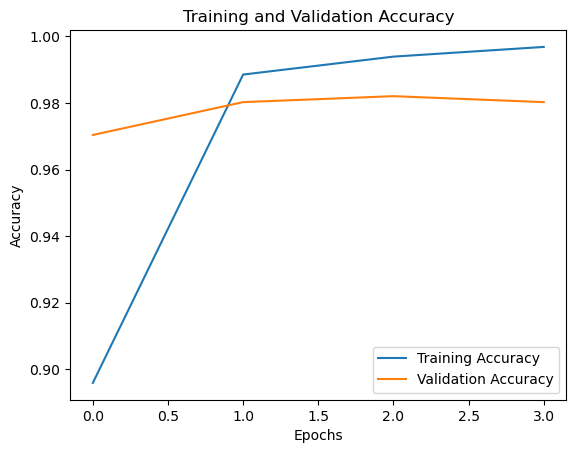

In [93]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def load_data(filepath):
    data = pd.read_csv(filepath, encoding='latin-1')
    data = data[['v1', 'v2']]
    data.columns = ['label', 'message']
    return data

def preprocess_data(data):
    encoder = LabelEncoder()
    data['label'] = encoder.fit_transform(data['label'])
    return data

def tokenize_and_pad(X_train, X_test, max_words=10000, max_seq_length=150):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)

    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_length)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=max_seq_length)
    
    return X_train_padded, X_test_padded, tokenizer

def build_model(max_words=10000, embedding_dim=32, max_seq_length=150):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_seq_length),
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[model_checkpoint, early_stopping])
    
    best_model = load_model('best_model.h5')
    return best_model, history

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


filepath = 'spam.csv'
data = load_data(filepath)
data = preprocess_data(data)
    
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.2, random_state=42)
X_train_padded, X_test_padded, tokenizer = tokenize_and_pad(X_train, X_test)
    
model = build_model()
best_model, history = train_and_evaluate_model(model, X_train_padded, y_train, X_test_padded, y_test)
    
plot_accuracy(history)